In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [3]:
### Your code is here
for col in data.loc[:,data.dtypes==np.object].columns:
    
    one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

### Your code is here
model = GradientBoostingClassifier(learning_rate=1, random_state=1, n_estimators=100)

model.fit(X_train, y_train)

fpr, tpr, tresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

round(auc(fpr, tpr), 3)

0.828

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [5]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [17]:
### Your code is here
from sklearn.metrics import classification_report

scores = []

for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        
        model = GradientBoostingClassifier(learning_rate=learning_rate, random_state=1, n_estimators=n_estimators, max_depth=5)

        model.fit(X_train, y_train)

        scores.append(f1_score(y_test, model.predict(X_test), average='weighted'))


In [18]:
sorted(scores)

[0.8310079575596817,
 0.8310079575596817,
 0.8310079575596817,
 0.8316268930523463,
 0.8317171483552103,
 0.8317171483552103,
 0.8319706786734022,
 0.8319706786734022,
 0.8319706786734022,
 0.8322241135533787,
 0.8348982048283926,
 0.8359832466969576,
 0.8360328757022755,
 0.8371109714914002,
 0.8374898105725385,
 0.8377279171194056,
 0.8384003359824256,
 0.8426079956106953,
 0.8426801637908706,
 0.8431243243243244,
 0.8440186407963912,
 0.8441822850241137,
 0.8460634986511725,
 0.8464474778638382]

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [8]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

forest_scores = []
deep_forest_scores = []
boost_scores = []
deep_boost_scores = []

### Your code is here

for n_estimators in n_estimators_list:
    
    forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=5)
    forest.fit(X_train, y_train)
    forest_scores.append(f1_score(y_test, forest.predict(X_test), average='weighted'))
    
    deep_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=5000)
    deep_forest.fit(X_train, y_train)
    deep_forest_scores.append(f1_score(y_test, deep_forest.predict(X_test), average='weighted'))
    
    boost = GradientBoostingClassifier(random_state=1, n_estimators=n_estimators, max_depth=5)
    boost.fit(X_train, y_train)
    boost_scores.append(f1_score(y_test, boost.predict(X_test), average='weighted'))
    
    deep_boost = GradientBoostingClassifier(random_state=1, n_estimators=n_estimators, max_depth=5000)
    deep_boost.fit(X_train, y_train)
    deep_boost_scores.append(f1_score(y_test, deep_boost.predict(X_test), average='weighted'))

In [13]:
for x in [forest_scores, deep_forest_scores, boost_scores, deep_boost_scores]:
    print(x)

[0.8307588219686919, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8310079575596817]
[0.846764031853822, 0.836785684903332, 0.8405950956937799, 0.8385382492696687, 0.8380366847826087, 0.8392955510658474, 0.8341676003504239, 0.8399263178630798, 0.8424589601225799, 0.8409130311682194, 0.8390595947985083, 0.8390797638582395, 0.8399690532389193]
[0.8310079575596817, 0.8310079575596817, 0.8322241135533787, 0.8319706786734022, 0.8319706786734022, 0.8317171483552103, 0.8316268930523463, 0.834352, 0.8377279171194056, 0.8431243243243244, 0.8426801637908706, 0.8460634986511725, 0.8374891415638304]
[0.8310079575596817, 0.8310079575596817, 0.8310079575596817, 0.8354112250447284, 0.8340867389491242, 0.8347121623087772, 0.8324214984474305, 0.8314386333356852, 0.8333481160316004, 0.8343872286709211, 0.8343872286709211, 0.834387

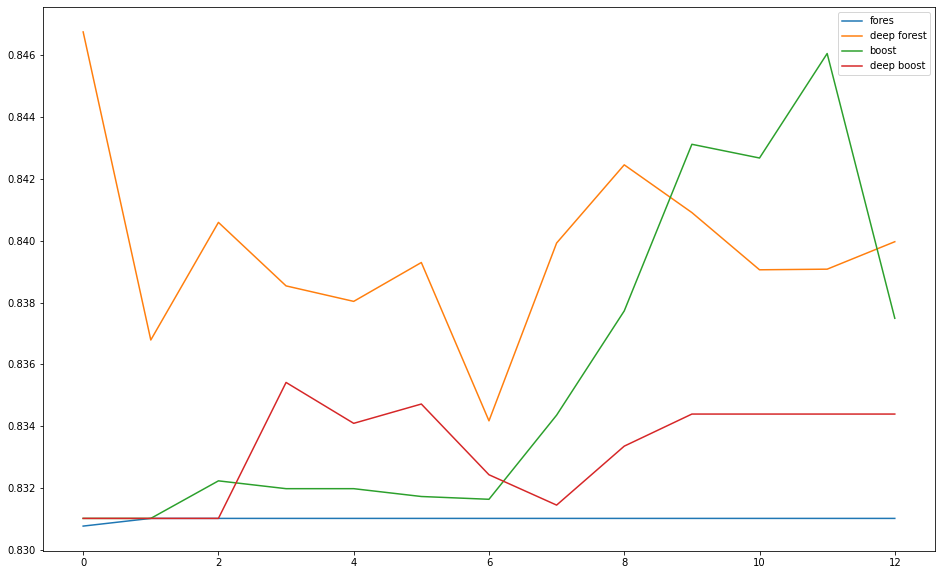

In [12]:
fig = plt.figure()
fig.set_size_inches(16, 10)

plt.plot(forest_scores)
plt.plot(deep_forest_scores)
plt.plot(boost_scores)
plt.plot(deep_boost_scores)
plt.legend(['fores', 'deep forest', 'boost', 'deep boost'])

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [14]:
! pip install catboost

You should consider upgrading via the '/nfs/env/bin/python -m pip install --upgrade pip' command.


In [20]:
from catboost import CatBoostClassifier

### Your code is here
cat_data = pd.read_csv('vehicle_insurance.csv')

X = cat_data.drop('Response', axis=1)
y = cat_data['Response']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [24]:
list(X.loc[:,X.dtypes==np.object].columns)

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [25]:
model = CatBoostClassifier()

model.fit(X_train, y_train, cat_features=list(X_train.loc[:,X_train.dtypes==np.object].columns))

Learning rate set to 0.025035
0:	learn: 0.6524209	total: 72.3ms	remaining: 1m 12s
1:	learn: 0.6213114	total: 78.1ms	remaining: 39s
2:	learn: 0.5922961	total: 84.4ms	remaining: 28.1s
3:	learn: 0.5658834	total: 91.7ms	remaining: 22.8s
4:	learn: 0.5423457	total: 98.5ms	remaining: 19.6s
5:	learn: 0.5180857	total: 107ms	remaining: 17.7s
6:	learn: 0.4986798	total: 114ms	remaining: 16.1s
7:	learn: 0.4802832	total: 121ms	remaining: 15s
8:	learn: 0.4619128	total: 129ms	remaining: 14.2s
9:	learn: 0.4465202	total: 136ms	remaining: 13.5s
10:	learn: 0.4341692	total: 143ms	remaining: 12.8s
11:	learn: 0.4204912	total: 152ms	remaining: 12.5s
12:	learn: 0.4147382	total: 162ms	remaining: 12.3s
13:	learn: 0.4094293	total: 172ms	remaining: 12.1s
14:	learn: 0.3996664	total: 178ms	remaining: 11.7s
15:	learn: 0.3902804	total: 185ms	remaining: 11.4s
16:	learn: 0.3851970	total: 193ms	remaining: 11.1s
17:	learn: 0.3768978	total: 200ms	remaining: 10.9s
18:	learn: 0.3694314	total: 208ms	remaining: 10.7s
19:	learn

In [26]:
model.feature_importances_

array([ 3.1033428 , 11.36658464,  0.03227638,  7.43228013, 27.35891126,
        4.74671151, 21.36760853,  9.26128996,  6.2198574 ,  9.11113739])

In [32]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

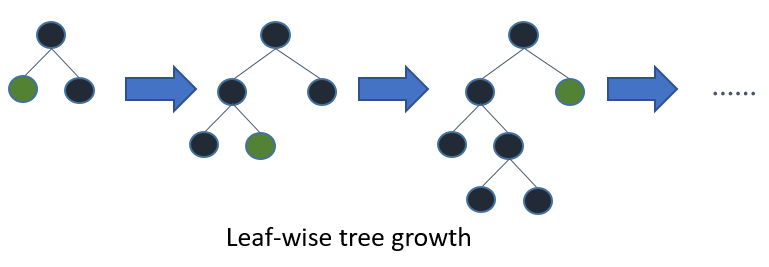

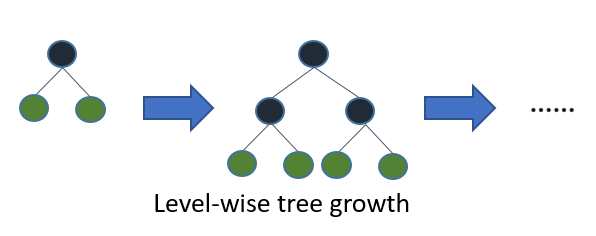

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [6]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

### Your code is here

model = LGBMClassifier()

search = GridSearchCV(model, params)

search.fit(X_train, y_train)



GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 100],
                         'n_estimators': [100, 500, 1000, 2000]})

In [8]:
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1770
           1       0.00      0.00      0.00       230

    accuracy                           0.89      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.78      0.89      0.83      2000

